<a href="https://colab.research.google.com/github/Eric428-a/-LMS-Learning-Management-System/blob/master/1_4_5_Portfolio_Management.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

First few rows of the dataset:
         date   open   high    low  close    volume Name
0  2013-02-08  15.07  15.12  14.63  14.75   8407500  AAL
1  2013-02-11  14.89  15.01  14.26  14.46   8882000  AAL
2  2013-02-12  14.45  14.51  14.10  14.27   8126000  AAL
3  2013-02-13  14.30  14.94  14.25  14.66  10259500  AAL
4  2013-02-14  14.94  14.96  13.16  13.99  31879900  AAL

Summary statistics of the dataset:
                open           high            low          close  \
count  619029.000000  619032.000000  619032.000000  619040.000000   
mean       83.023334      83.778311      82.256096      83.043763   
std        97.378769      98.207519      96.507421      97.389748   
min         1.620000       1.690000       1.500000       1.590000   
25%        40.220000      40.620000      39.830000      40.245000   
50%        62.590000      63.150000      62.020000      62.620000   
75%        94.370000      95.180000      93.540000      94.410000   
max      2044.000000    2067.990000    

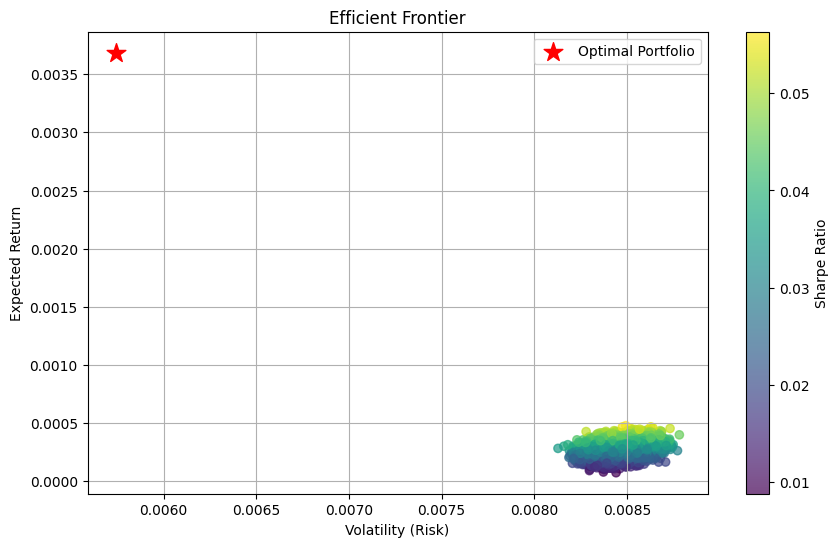

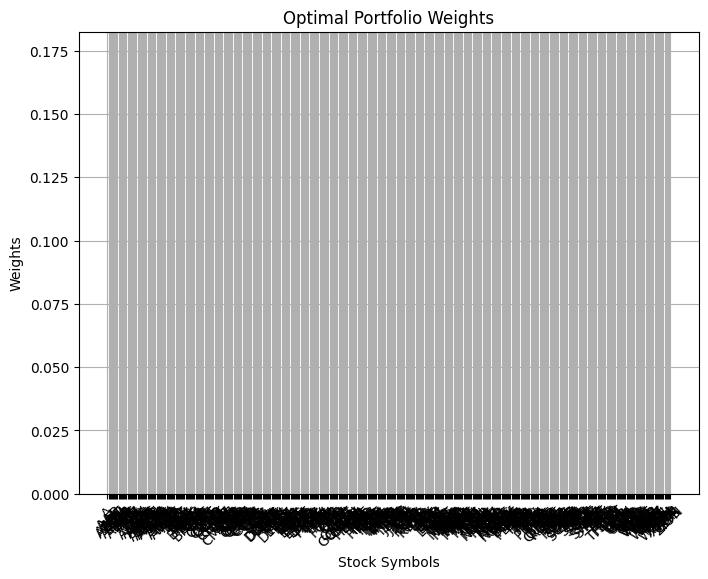

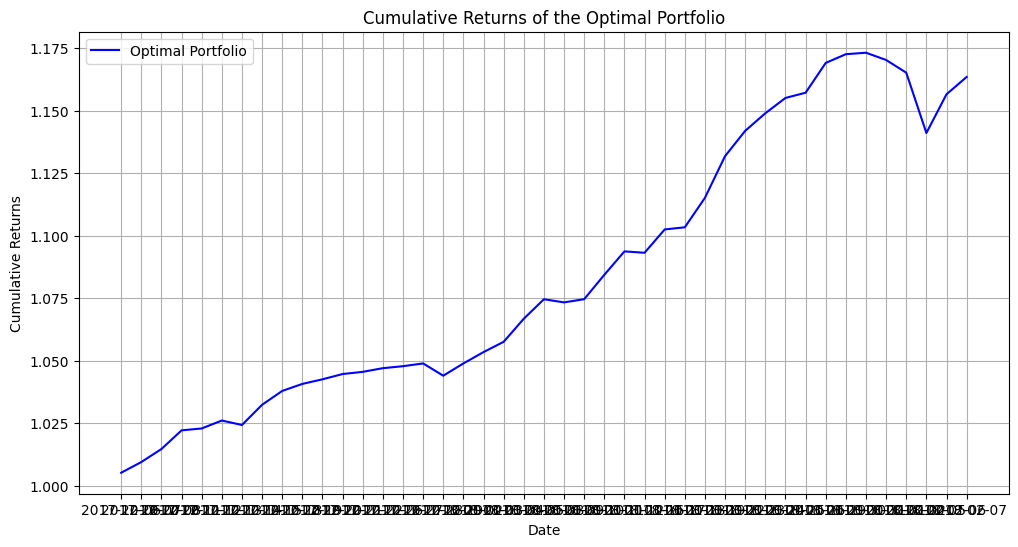

In [17]:
import pandas as pd  # Import pandas library for data manipulation
import numpy as np  # Import numpy library for numerical operations
from scipy.optimize import minimize  # Import minimize function from scipy.optimize for optimization
import matplotlib.pyplot as plt  # Import matplotlib.pyplot for plotting

# Step 1: Load and Explore Data
file_path = "/content/all_stocks_5yr.csv"  # File path to the dataset
df = pd.read_csv(file_path)  # Load the dataset into a pandas DataFrame
print("First few rows of the dataset:")  # Display the first few rows of the dataset
print(df.head())  # Print the first few rows of the dataset
print("\nSummary statistics of the dataset:")  # Display the summary statistics
print(df.describe())  # Print the summary statistics of the dataset
print("\nInformation about dataset columns:")  # Display information about the dataset columns
print(df.info())  # Print information about the dataset columns

# Step 2: Data Preprocessing and Calculation
df.dropna(inplace=True)  # Drop rows with any missing values
df_pivot = df.pivot(index='date', columns='Name', values='close')  # Pivot the dataframe for portfolio analysis
returns = df_pivot.pct_change().dropna()  # Calculate daily returns

# Step 3: Portfolio Optimization Functions
def calculate_portfolio_performance(weights, mean_returns, cov_matrix):
    portfolio_return = np.sum(mean_returns * weights)  # Calculate portfolio return
    portfolio_std_dev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))  # Calculate portfolio standard deviation
    return portfolio_return, portfolio_std_dev  # Return portfolio return and standard deviation

def objective_function(weights, mean_returns, cov_matrix, risk_free_rate):
    portfolio_return, portfolio_std_dev = calculate_portfolio_performance(weights, mean_returns, cov_matrix)
    utility = (portfolio_return - risk_free_rate) / portfolio_std_dev  # Calculate portfolio utility (Sharpe ratio)
    return -utility  # Maximize utility is equivalent to minimizing negative utility

def optimize_portfolio(mean_returns, cov_matrix, risk_free_rate):
    num_assets = len(mean_returns)  # Number of assets
    initial_weights = np.array([1 / num_assets] * num_assets)  # Initial equal weights for optimization
    constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})  # Sum of weights constraint
    bounds = tuple((0, 1) for _ in range(num_assets))  # Bounds for weights
    result = minimize(objective_function, initial_weights, args=(mean_returns, cov_matrix, risk_free_rate),
                      method='SLSQP', bounds=bounds, constraints=constraints)  # Minimize objective function
    return result.x  # Return optimal weights

# Step 4: Optimize Portfolio
mean_returns = returns.mean()  # Calculate mean returns
cov_matrix = returns.cov()  # Calculate covariance matrix
risk_free_rate = 0.0  # Set risk-free rate (assume 0 for this example)
optimal_weights = optimize_portfolio(mean_returns, cov_matrix, risk_free_rate)  # Optimize portfolio weights

# Print optimal portfolio weights
print("\nOptimal Portfolio Weights:")
for i, symbol in enumerate(df_pivot.columns):
    print(f"{symbol}: {optimal_weights[i]:.4f}")

# Calculate expected portfolio return and volatility
optimal_return, optimal_volatility = calculate_portfolio_performance(optimal_weights, mean_returns, cov_matrix)

print("\nOptimal Portfolio:")
print(f"Expected Annual Return: {optimal_return:.4f}")  # Print expected annual return
print(f"Annual Volatility (Risk): {optimal_volatility:.4f}")  # Print annual volatility

# Step 5: Generate and Plot Random Portfolios
num_portfolios = 10000  # Number of random portfolios
results = np.zeros((3, num_portfolios))  # Initialize array for results
for i in range(num_portfolios):
    weights = np.random.random(len(df_pivot.columns))  # Generate random weights
    weights /= np.sum(weights)  # Normalize weights
    portfolio_return, portfolio_std_dev = calculate_portfolio_performance(weights, mean_returns, cov_matrix)
    results[0,i] = portfolio_return  # Save portfolio return
    results[1,i] = portfolio_std_dev  # Save portfolio standard deviation
    results[2,i] = (portfolio_return - risk_free_rate) / portfolio_std_dev  # Save Sharpe ratio

# Step 6: Plot random portfolios and Efficient Frontier
plt.figure(figsize=(10, 6))  # Set figure size
plt.scatter(results[1,:], results[0,:], c=results[2,:], marker='o', cmap='viridis', alpha=0.7)  # Scatter plot of portfolios
plt.colorbar(label='Sharpe Ratio')  # Add colorbar for Sharpe ratio
plt.scatter(optimal_volatility, optimal_return, marker='*', color='r', s=200, label='Optimal Portfolio')  # Mark optimal portfolio
plt.title('Efficient Frontier')  # Set title
plt.xlabel('Volatility (Risk)')  # Set x-axis label
plt.ylabel('Expected Return')  # Set y-axis label
plt.legend()  # Show legend
plt.grid(True)  # Show grid
plt.show()  # Display plot

# Step 7: Visualize Optimal Portfolio Weights
plt.figure(figsize=(8, 6))  # Set figure size
plt.bar(df_pivot.columns, optimal_weights)  # Bar plot of optimal weights
plt.title('Optimal Portfolio Weights')  # Set title
plt.xlabel('Stock Symbols')  # Set x-axis label
plt.ylabel('Weights')  # Set y-axis label
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(True)  # Show grid
plt.show()  # Display plot

# Step 8: Calculate and Plot Cumulative Returns of the Optimal Portfolio
cumulative_returns = (1 + returns).cumprod()  # Calculate cumulative returns
optimal_portfolio_returns = np.dot(cumulative_returns, optimal_weights)  # Calculate optimal portfolio returns

plt.figure(figsize=(12, 6))  # Set figure size
plt.plot(cumulative_returns.index, optimal_portfolio_returns, label='Optimal Portfolio', linestyle='-', color='blue')  # Plot cumulative returns
plt.title('Cumulative Returns of the Optimal Portfolio')  # Set title
plt.xlabel('Date')  # Set x-axis label
plt.ylabel('Cumulative Returns')  # Set y-axis label
plt.legend()  # Show legend
plt.grid(True)  # Show grid
plt.show()  # Display plot
